## Abstract

Prédire à quelle oeuvre A ou B  appartient une phrase donnée, voilà le sujet de ce notebook. On aura pris soin de choisir des oeuvres présentant un niveau de langue différent avec pour l'oeuvre A: Moby Dick de Melville et l'oeuvre B : Harry Potter de J.K Rowling. 

## Résultat

Le modèle permet de classifier correctement une phrase prise au hasard du jeu de validation 96 fois sur 100.

### Bibliothèqes utilisées <a class="anchor" id="chapter1"></a>

In [1]:
# Générique data project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pour la manipulation de fichiers
import os
import glob
from pathlib import Path

# Prépa données
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Deep learning
import tensorflow as tf
from tensorflow.keras.layers import RNN,GRUCell,Dropout,GlobalAveragePooling1D,Dense,Embedding
from tensorflow.keras import Sequential

# Txt mining
import re

# MISC
import warnings
warnings.filterwarnings("ignore")
import swifter
import random

### Setup & exploration <a class="anchor" id="chapter2"></a>

On récupère les oeuvre A : Moby dick et B : Harry Potter

In [2]:
with open('melville-moby_dick.txt','r',encoding ='utf-8') as file :
    A = file.read()
    
with open('Book1.txt','r',encoding ='utf-8') as file :
    B = file.read()

On renseigne chaque phrase dans une liste, pour l'oeuvre A. L'oeuvre B est construite de sorte qu'il faut d'abord suppriemr les pieds de pages

In [3]:
from nltk.tokenize import PunktSentenceTokenizer

tokenizer_A = PunktSentenceTokenizer()
Moby_dick = tokenizer_A.tokenize(A)



On supprime le \n et on bâti une liste contenant chaque phrase de l'oeuvre

In [4]:
def filtre_A(txt):
    r = re.compile(r"[^\n]+")
    temp = r.findall(txt)
    return ' '.join(temp)

def filtre_B(txt):
    r = re.compile(r"[^\n]+")
    temp = r.findall(txt)
    txt_2 = ' '.join(temp)
    
    s = re.compile(r"\D")
    temp2 = s.findall(txt_2)
                   
    return ' '.join(temp2)


In [5]:
Moby = [element for liste in Moby_dick for element in filtre_A(liste) ]
Moby2 = ''.join(Moby)
Moby3 = Moby2.split('.')

Harry = [element for liste in B for element in filtre_B(liste) ]
Harry2 = ''.join(Harry)
Harry3 = Harry2.replace('Page |  Harry Potter and the Philosophers Stone - J.K. Rowling','')
Harry4 = Harry3.replace('Mr.','Mr')
Harry5 = Harry4.replace('Mrs.','Mrs')
Harry6 = Harry5.split('.')

On crée les dataframes associées:

In [6]:
df_A = pd.DataFrame(Moby3,columns=['Sentence'])
df_A['oeuvre']=0

df_B = pd.DataFrame(Harry6,columns=['Sentence'])
df_B['oeuvre']=1

On concatène les deux dataframe et on procèdes aux opérations suivantes:

In [7]:
df = pd.concat([df_A,df_B],axis = 0).reset_index().drop(['index'],axis = 1)

# On récupère le nombre de character de chaque phrase
df['num_char'] = df.Sentence.apply(lambda x : len(x))

# On élimine les espaces
df = df[df['num_char']>0].reset_index().drop(['index'],axis = 1)

On affiche la distribution

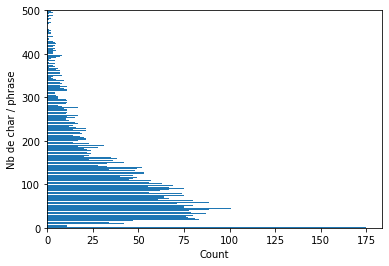

In [8]:
plt.barh(df.num_char.value_counts().index,df.num_char.value_counts().values)
plt.xlabel('Count')
plt.ylabel('Nb de char / phrase')
plt.ylim([0,500])
plt.show()

Une phrase de 100 caractères semble suffisante pour conduire l'analyse:

In [9]:
data = df[df['num_char']>=100].reset_index().drop(['index'],axis = 1)
data['phrase']=data.Sentence.apply(lambda x : x[:100])

On récupère la liste des mots

In [10]:
def filtre_mot(texte):
    r = re.compile(r"\W+")
    return r.split(texte)
                   
word = [element for liste in data.phrase.values for element in filtre_mot(liste)]

On stocke dans une liste tous les mots uniques

In [11]:
unik_word = sorted(set(word))

In [12]:
len(unik_word)

13658

Dans la mesure où les algorithmes ne traitent que des nombres, il nous faut transformer chaque phrase en liste d'entier. On produit pour chaque phrase une liste des mots qui la compose puis on y associera une liste d'entier


In [13]:
# On transforme chaque phrase en liste de mot
data['liste_mot'] = data['phrase'].apply(lambda x : filtre_mot(x))

# On vérifie le nombre de mot contenu dans chaque liste et on retient le nombre le plus faible
data['verif'] = data.liste_mot.apply(lambda x: len(x))

# On ne conserve pour chaque liste que le s11 premeirs termes
data['final']=data.liste_mot.apply(lambda x : x[:11])

# On vérifie
data['verif2'] = data.final.apply(lambda x: len(x))
data.verif2.unique()

array([11], dtype=int64)

On vérifie que les classes ne sont pas déséqulibrées

In [14]:
data.oeuvre.value_counts()

0    4527
1    1418
Name: oeuvre, dtype: int64

On affiche la dataframe finale support à l'analyse

In [15]:
data

,Sentence,oeuvre,num_char,phrase,liste_mot,verif,final,verif2
0,Some years ago--never mind how long precisely-...,0,208,Some years ago--never mind how long precisely-...,"[Some, years, ago, never, mind, how, long, pre...",19,"[Some, years, ago, never, mind, how, long, pre...",11
1,Whenever I find myself growing grim about the ...,0,493,Whenever I find myself growing grim about the ...,"[Whenever, I, find, myself, growing, grim, abo...",19,"[Whenever, I, find, myself, growing, grim, abo...",11
2,"If they but knew it, almost all men in their d...",0,136,"If they but knew it, almost all men in their d...","[If, they, but, knew, it, almost, all, men, in...",20,"[If, they, but, knew, it, almost, all, men, in...",11
3,There now is your insular city of the Manhatto...,0,141,There now is your insular city of the Manhatto...,"[There, now, is, your, insular, city, of, the,...",19,"[There, now, is, your, insular, city, of, the,...",11
4,"Its extreme downtown is the battery, where tha...",0,154,"Its extreme downtown is the battery, where tha...","[Its, extreme, downtown, is, the, battery, whe...",18,"[Its, extreme, downtown, is, the, battery, whe...",11
...,...,...,...,...,...,...,...,...
5940,"And suddenly, their wardrobes were empty, the...",1,694,"And suddenly, their wardrobes were empty, the...","[, And, suddenly, their, wardrobes, were, empt...",17,"[, And, suddenly, their, wardrobes, were, empt...",11
5941,A wizened old guard was up by the ticket barr...,1,204,A wizened old guard was up by the ticket barr...,"[, A, wizened, old, guard, was, up, by, the, t...",21,"[, A, wizened, old, guard, was, up, by, the, t...",11
5942,"“There he is, Mom, there he is, look!” It wa...",1,115,"“There he is, Mom, there he is, look!” It wa...","[, There, he, is, Mom, there, he, is, look, It...",22,"[, There, he, is, Mom, there, he, is, look, It...",11
5943,"” “Ready, are you?” It was Uncle Vernon, still...",1,185,"” “Ready, are you?” It was Uncle Vernon, still...","[, Ready, are, you, It, was, Uncle, Vernon, st...",17,"[, Ready, are, you, It, was, Uncle, Vernon, st...",11


On transforme chaque liste de mot en séquence d'entier, sur la base des mots uniques précédemment obtenus

In [16]:
tokenizer_word = tf.keras.preprocessing.text.Tokenizer(num_words=len(unik_word))
tokenizer_word.fit_on_texts(data.final)

X = tokenizer_word.texts_to_sequences(data.final)


On confirme via la méthode ci-dessous que chaque séquence présente bien 11 élements

In [17]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=11, padding='post', truncating='post')

On sépare le jeu en train et test

In [18]:
X_train_top,X_test_top,y_train_top,y_test_top = train_test_split(X,data.oeuvre,test_size = 0.3,random_state = 1234,shuffle = True)

On présente les données sous format array numpy

In [19]:
X_train_top = np.asarray(X_train_top)
X_test_top = np.asarray(X_test_top)
y_train_top = np.asarray(y_train_top)
y_test_top = np.asarray(y_test_top)

print(f'shape of X_train_top : {X_train_top.shape}')
print(f'shape of X_test_top : {X_test_top.shape}')
print(f'shape of y_train_top : {y_train_top.shape}')
print(f'shape of y_test_top : {y_test_top.shape}')

shape of X_train_top : (4161, 11)
shape of X_test_top : (1784, 11)
shape of y_train_top : (4161,)
shape of y_test_top : (1784,)


On crée les dictionnaires de correspondances

In [20]:

word2idx = tokenizer_word.word_index
idx2word = tokenizer_word.index_word
vocab_word_size = tokenizer_word.num_words

On instancie et on entraine un modele RNN

In [21]:
model = tf.keras.Sequential()

model.add(Embedding(vocab_word_size+1,256,input_length=11))
model.add(RNN(GRUCell(256),return_sequences = False))
model.add(Dropout(0.4))

model.add(Dense(256,'relu'))

model.add(Dropout(0.3))

model.add(Dense(1,'sigmoid'))

epok = 15

opt = tf.keras.optimizers.Adam(learning_rate=0.007)

model.compile(loss = 'binary_crossentropy',optimizer ='adam',metrics =["accuracy"])

training_history = model.fit(X_train_top,y_train_top,validation_data=(X_test_top,y_test_top) ,epochs = epok, batch_size = 128)

Epoch 1/15
33/33 [==============================] - 5s 87ms/step - loss: 0.4651 - accuracy: 0.7818 - val_loss: 0.1250 - val_accuracy: 0.9524
Epoch 2/15
33/33 [==============================] - 2s 75ms/step - loss: 0.0741 - accuracy: 0.9716 - val_loss: 0.1341 - val_accuracy: 0.9322
Epoch 3/15
33/33 [==============================] - 3s 77ms/step - loss: 0.0192 - accuracy: 0.9933 - val_loss: 0.1013 - val_accuracy: 0.9658
Epoch 4/15
33/33 [==============================] - 3s 76ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.1210 - val_accuracy: 0.9636
Epoch 5/15
33/33 [==============================] - 3s 77ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.1376 - val_accuracy: 0.9619
Epoch 6/15
33/33 [==============================] - 3s 78ms/step - loss: 6.1034e-04 - accuracy: 1.0000 - val_loss: 0.1390 - val_accuracy: 0.9630
Epoch 7/15
33/33 [==============================] - 2s 76ms/step - loss: 1.2689e-04 - accuracy: 1.0000 - val_loss: 0.1514 - val_accuracy: 0.9619
Epoch

On affiche l'évolution de l'accuracy pour le train et le test

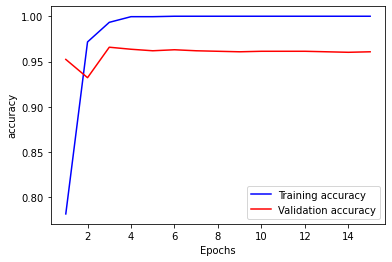

In [22]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('accuracy')

plt.plot(np.arange(1,epok +1,1),training_history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(np.arange(1,epok +1,1),training_history.history['val_accuracy'], label='Validation accuracy', color='red')

plt.legend()

plt.show()

On produit la prédiction des classes à partir du jeu de test

In [23]:
y_sigmoid = model.predict(X_test_top)
y_pred = np.round(y_sigmoid).reshape(-1)

On définit une fonction pour afficher la matrice de confusion

In [24]:
def plot_cm(*args): # On crée une fonction pour afficher une ou plusieurs matrices de confusion

    liste =[]
    for i in args:
        liste.append(i)

    classes = range(2)
    if len(liste)>=2:
        plt.figure(figsize=(len(liste)+8,len(liste)+8))
    else:
        plt.figure(figsize=(len(liste)+4,len(liste)+4))

    for k,val in enumerate(liste):

        plt.subplot(1,len(liste),k+1)
        plt.imshow(val,cmap ='ocean')
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks,classes)
        plt.yticks(tick_marks,classes)
        plt.grid(False)
        plt.ylabel('réalité')
        plt.xlabel('prédiction')
        #plt.title(f'name[k])

        for i in range(liste[k].shape[0]):
            for j in range(liste[k].shape[1]):
        
                plt.text(i,j,liste[k][j,i])
           
    plt.show()

On affiche la matrice de confusion

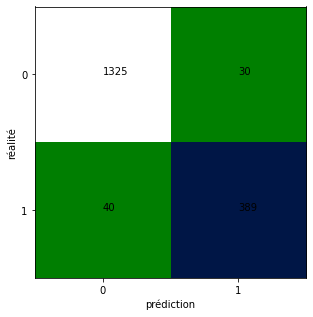

In [25]:
cm = confusion_matrix(y_test_top, y_pred)
plot_cm(cm)

On affiche le rapport de classification

In [26]:

target_names=['Moby Dick','Harry Potter']
print(classification_report(y_test_top, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Moby Dick       0.97      0.98      0.97      1355
Harry Potter       0.93      0.91      0.92       429

    accuracy                           0.96      1784
   macro avg       0.95      0.94      0.95      1784
weighted avg       0.96      0.96      0.96      1784

